# Matching Gravitationally Lensed SNe (GLSNe) Lens Galaxies to CosmoDC2 galaxies

Last updated: _Bryce Kalmbach, December 2018_

Danny Goldstein's latest strongly lensed SNe catalog has all the properties needed to replace galaxies from DC2 with the sprinkler except for SEDs and CatSim magNorm values for the lens galaxies. This notebook matches the lensed SNe lens galaxies to a DC2 galaxy then uses `sims_GCRCatSimInterface` and the given 'i-band' magnitude from the lens catalog to calculate an appropriate magNorm value and SED.


## Requirements

You will need `gcrCatalogs`, `GCR`, `pandas`, `numpy` and `matplotlib`

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
import os
from lsst.sims.photUtils import Sed, Bandpass, BandpassDict

%matplotlib inline

#### Load up the input lensed SNe catalogs

In [2]:
dc2_df_system = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2.h5', key='system')
dc2_df_image = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2.h5', key='image')

In [3]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

#### Choose an area of the DC2 catalog to use for matching galaxies

In [4]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_10194_10452')

In [5]:
# Example lens catalog row.
dc2_df_system.iloc[0]

t0                               62307.9
sigma                             197.67
gamma                           0.128101
e                               0.570391
theta_e                          132.165
theta_gamma                       135.21
zs                              0.435736
zl                              0.152485
snx                            -0.136216
sny                             0.144903
MB                              -19.3306
transient_amplitude          7.78584e-10
sysno                               2237
sntype                                1a
ebvhost                        0.0735387
ra                               132.817
dec                             -34.6162
ebvmw                           0.283343
weight                       0.000133177
host_n                                 1
host_ellip                          0.84
host_reff                       0.810876
host_theta                       5.70672
host_amplitude               4.93238e-17
host_type       

#### Get all the galaxies from the catalog that are within the redshift range and i-band magnitude range of the lens galaxies

In [6]:
%%time
z_cat_min = np.power(10, np.log10(np.min(dc2_df_system['zl'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(dc2_df_system['zl'])) + .1)

i_gal_dim = np.max(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*.9))
i_gal_bright = np.min(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*1.1))

print(z_cat_min, z_cat_max, i_gal_dim, i_gal_bright)

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'ellipticity_true', 'mag_true_i_lsst',
                               'size_minor_bulge_true', 'size_bulge_true'],
                              filters=['mag_true_i_lsst > %f' % i_gal_bright,
                                       'mag_true_i_lsst < %f' % i_gal_dim,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

data['glsne_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))


data_df = pd.DataFrame(data)
print(data_df.head(10))

0.011915068367 1.25738633782 26.4773769233 9.67143111596
   ellipticity_true   galaxy_id  glsne_ellipticity  mag_true_i_lsst  \
0          0.105070  6000000125           0.187972        14.337171   
1          0.260718  6000000798           0.405843        13.872838   
2          0.024329  6000001056           0.043976        16.248610   
3          0.042866  6000001342           0.079657        14.812760   
4          0.197311  6000001548           0.298066        16.810287   
5          0.287196  6000001898           0.444674        15.766129   
6          0.008977  6000002102           0.017794        16.222540   
7          0.004133  6000005327           0.008101        24.895262   
8          0.130662  6000006654           0.225599        21.406273   
9          0.160738  6000007652           0.275020        23.113390   

   redshift_true  size_bulge_true  size_minor_bulge_true  
0       0.018053         3.953189               3.210100  
1       0.029891         6.196536          

#### Use this set of DC2 galaxies to then match to each lens galaxy in the catalog based upon redshift and i-band apparent magnitude

In [7]:
%%time
gcr_glsn_match = []
err = 0
np.random.seed(10)
i = 0

row_num = -1
keep_rows = []
num_match_total = []

for zsrc, i_mag_star in zip(dc2_df_system['zl'].values,
                            dc2_df_system['lensgal_mi'].values):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 10000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    i_mag_dim, i_mag_bright = -2.5*np.log10(np.power(10, -0.4*i_mag_star)*.9),\
                              -2.5*np.log10(np.power(10, -0.4*i_mag_star)*1.1)
    #ellip_min, ellip_max = ellip*.9, ellip*1.1
    #r_major = r_eff / np.sqrt(1 - ellip)
    #r_major_max, r_major_min = r_major*1.1, r_major*.9
    
    
    #print(z_min, z_max, i_mag_min, i_mag_max, ellip_min, ellip_max)
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f ' % (z_min, z_max)
                                + 'and mag_true_i_lsst > %f and mag_true_i_lsst < %f ' % (i_mag_bright, i_mag_dim)
                                #+ 'and glsne_ellipticity > %f and glsne_ellipticity < %f' % (ellip_min, ellip_max)
                                #+ 'and size_bulge_true > %f and size_bulge_true < %f' % (r_major_min, r_major_max)
                               )
    
    num_matches = len(data_subset['redshift_true'])

    num_match_total.append(num_matches)
    
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['galaxy_id'].values[0]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(dc2_df_system))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
Total Match Failures:  13359  Percentage Match Failures:  0.06787454463237798
CPU times: user 1h 46min 7s, sys: 29.4 s, total: 1h 46min 37s
Wall time: 1h 13min 24s


In [8]:
gcr_glsn_match = np.array(gcr_glsn_match)

(array([ 41263.,  38925.,  30657.,  18788.,  16507.,  10575.,   6967.,
          5401.,   4214.,   3026.,   2201.,   1417.,    956.,    650.,
           483.,    403.,    263.,    221.,    164.,    135.]),
 array([ 0.01500018,  0.06418905,  0.11337791,  0.16256678,  0.21175564,
         0.2609445 ,  0.31013337,  0.35932223,  0.4085111 ,  0.45769996,
         0.50688883,  0.55607769,  0.60526655,  0.65445542,  0.70364428,
         0.75283315,  0.80202201,  0.85121088,  0.90039974,  0.94958861,
         0.99877747]),
 <a list of 20 Patch objects>)

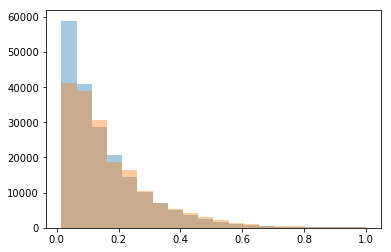

In [9]:
n, bins, _ = plt.hist(dc2_df_system['zl'], alpha=0.4, bins=20)
plt.hist(gcr_glsn_match[:,0], alpha=0.4, bins=bins)

In [11]:
np.savetxt('gcr_glsn_match.txt', gcr_glsn_match)

It seems we are missing mostly very low redshift systems. This is most likely a result of our percentage bounds on redshift. However, we still have over 40000 systems in this low redshift range and will have enough to match.

## Matching to SEDs using `sims_GCRCatSimInterface`

Our goal is to add SEDs and magNorm values into the lensing catalogs for the lens galaxies. Here we get the top hat filters out of cosmoDC2 and use the code in `sims_GCRCatSimInterface` to match these values to a CATSIM SED file in the same way the galaxies are matched for Instance Catalog production in DC2. We also use the code to calculate the magnitude normalization for PhoSim.

In [12]:
from desc.sims.GCRCatSimInterface import sed_from_galacticus_mags

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 28 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [13]:
H0 = catalog.cosmology.H0.value
Om0 = catalog.cosmology.Om0

In [14]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and quant_label.endswith('bulge')):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

Check to see that our bins are now in order when we call them.

In [15]:
for i in zip(sed_label, sed_min_wave, sed_wave_width):
    print(i)

('sed_1000_246_bulge', 100.0, 24.600000000000001)
('sed_1246_306_bulge', 124.59999999999999, 30.600000000000001)
('sed_1552_381_bulge', 155.19999999999999, 38.100000000000001)
('sed_1933_474_bulge', 193.30000000000001, 47.399999999999999)
('sed_2407_591_bulge', 240.69999999999999, 59.100000000000001)
('sed_2998_186_bulge', 299.80000000000001, 18.600000000000001)
('sed_3184_197_bulge', 318.39999999999998, 19.699999999999999)
('sed_3381_209_bulge', 338.10000000000002, 20.899999999999999)
('sed_3590_222_bulge', 359.0, 22.199999999999999)
('sed_3812_236_bulge', 381.19999999999999, 23.600000000000001)
('sed_4048_251_bulge', 404.80000000000001, 25.100000000000001)
('sed_4299_266_bulge', 429.89999999999998, 26.600000000000001)
('sed_4565_283_bulge', 456.5, 28.300000000000001)
('sed_4848_300_bulge', 484.80000000000001, 30.0)
('sed_5148_319_bulge', 514.79999999999995, 31.899999999999999)
('sed_5467_339_bulge', 546.70000000000005, 33.899999999999999)
('sed_5806_360_bulge', 580.60000000000002, 36

In [16]:
del(data)
del(data_df)

In [18]:
%%time
columns = ['galaxy_id', 'redshift_true']
for sed_bin in sed_label:
    columns.append(sed_bin)
data = catalog.get_quantities(columns,
                              filters=['mag_true_i_lsst > %f' % i_gal_bright,
                                       'mag_true_i_lsst < %f' % i_gal_dim,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])
data_df = pd.DataFrame(data)

CPU times: user 57.3 s, sys: 55.6 s, total: 1min 52s
Wall time: 5min 20s


In [19]:
gcr_z = []
gcr_gal_id = []
for row in gcr_glsn_match:
    gcr_z.append(row[0])
    gcr_gal_id.append(row[1])

In [20]:
%%time
sed_name_list = []
magNorm_list = []
i = 0
for gal_id, gal_z in zip(gcr_gal_id, gcr_z):
    
    if i % 10000 == 0:
        print(i)
    i+=1
    
    data_subset = data_df.query(str('galaxy_id == %i' % gal_id + ' and ' + 'redshift_true == {}'.format(gal_z))) ## Galaxy Ids are not unique in cosmoDC2_v0.1
    mag_array = []
    for sed_bin in sed_label:
        mag_array.append(-2.5*np.log10(data_subset[sed_bin].values[0]))
    mag_array = np.array(mag_array)
    sed_name, magNorm = sed_from_galacticus_mags(np.array([mag_array]).T, np.array([gal_z]), H0, Om0, sed_min_wave, sed_wave_width)
    sed_name_list.append(sed_name)
    magNorm_list.append(magNorm)
print(len(sed_name_list), len(keep_rows))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
183460 183460
CPU times: user 1h 14min 1s, sys: 14.4 s, total: 1h 14min 15s
Wall time: 56min 55s


In [21]:
sed_name_array = np.array(sed_name_list)
magNorm_array = np.array(magNorm_list)

In [26]:
np.savetxt('sed_name_list.txt', sed_name_array, fmt='%s')
np.savetxt('magNorm_list.txt', magNorm_array)

In [72]:
test_bandpassDict = BandpassDict.loadTotalBandpassesFromFiles()

In [74]:
imsimband = Bandpass()
imsimband.imsimBandpass()

In [79]:
mag_norm_glsne = []
for i, idx in list(enumerate(keep_rows)):
    if i % 10000 == 0:
        print(i, idx)
    test_sed = Sed()
    test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[i][0]))
    fnorm = test_sed.calcFluxNorm(dc2_df_system['lensgal_mi'].iloc[idx], test_bandpassDict['i'])
    test_sed.multiplyFluxNorm(fnorm)
    mag_norm_glsne.append(test_sed.calcMag(imsimband))

0 0
10000 10728
20000 21485
30000 32199
40000 42923
50000 53649
60000 64396
70000 75131
80000 85862
90000 96584
100000 107277
110000 118011
120000 128730
130000 139431
140000 150172
150000 160931
160000 171687
170000 182376
180000 193128


In [80]:
mag_norm_glsne = np.array(mag_norm_glsne)

In [81]:
sed_metals = []
sed_ages = []
sed_metals_dict = {'0005Z':'.005', '002Z':'.02', '02Z':'.2', '04Z':'.4', '1Z':'1.0', '25Z':'2.5'}
for sed_template in sed_name_array:
    sed_info = sed_template[0].split('/')[1].split('.')
    sed_age_info = sed_info[1].split('E')
    sed_ages.append(np.power(10, int(sed_age_info[1]))*int(sed_age_info[0]))
    sed_metals.append(sed_metals_dict[sed_info[2]])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


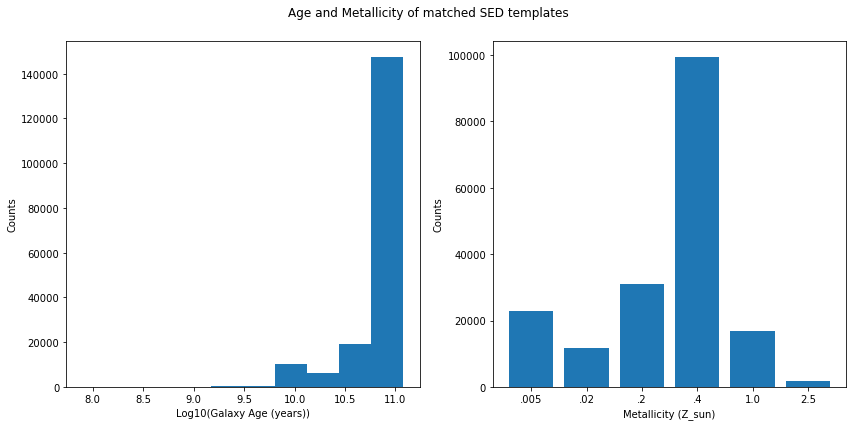

In [82]:
fig = plt.figure(figsize=(12, 6))
mpl.rcParams['text.usetex'] = False
fig.add_subplot(1,2,1)
plt.hist(np.log10(sed_ages))
plt.xlabel('Log10(Galaxy Age (years))')
plt.ylabel('Counts')
fig.add_subplot(1,2,2)
names, counts = np.unique(sed_metals, return_counts=True)
x = np.arange(len(names), dtype=int)
plt.bar(x, counts)
plt.xticks(x, names)
plt.xlabel('Metallicity (Z_sun)')
plt.ylabel('Counts')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Age and Metallicity of matched SED templates')

We want our lens galaxies to be large, red ellipticals and it looks like we are getting older, redder galaxies which looks like we are succeeding.

## Adding new info to Twinkles GLSNe catalog

We will take all the columns currently in the Twinkles GLSNe catalog and add in our new SED filenames and SED magnitude normalizations for PhoSim.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


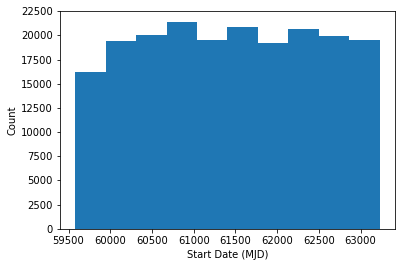

In [29]:
# Double check the distribution of t0
mpl.rcParams['text.usetex'] = False
plt.hist(dc2_df_system['t0'])
plt.xlabel('Start Date (MJD)')
plt.ylabel('Count')

In the final catalog we produce we only want to include the systems we were able to match to a `gcr` galaxy.

In [83]:
results_dict = {}
print(len(keep_rows), len(gcr_z))
for keep_idx in range(len(keep_rows)):
    results_dict[str(dc2_df_system['sysno'].iloc[keep_rows[keep_idx]])] = {'z':gcr_z[keep_idx],
                                                                           'sed_name':sed_name_array[keep_idx],
                                                                           'magNorm':mag_norm_glsne[keep_idx]}

183460 183460


In [84]:
keep_systems = dc2_df_system['sysno'].iloc[keep_rows].values

In [87]:
final_df_z = []
final_df_lens_sed = []
final_df_magNorm = []

keep_in_df = []

for idx, twinkles_sys in enumerate(dc2_df_system['sysno']):
    if twinkles_sys in keep_systems:
        keep_in_df.append(idx)
        final_df_z.append(results_dict[str(twinkles_sys)]['z'])
        final_df_lens_sed.append(results_dict[str(twinkles_sys)]['sed_name'][0])
        final_df_magNorm.append(results_dict[str(twinkles_sys)]['magNorm'])

In [90]:
final_df = dc2_df_system.iloc[keep_in_df]
final_df = final_df.reset_index(drop=True)

In [91]:
final_df['lensgal_magnorm'] = final_df_magNorm
final_df['lensgal_sed'] = final_df_lens_sed

In [92]:
final_df.head()

,t0,sigma,gamma,e,theta_e,theta_gamma,zs,zl,snx,sny,...,lensgal_type,lensgal_x,lensgal_y,t_found,lensgal_mi,x0,x1,c,lensgal_magnorm,lensgal_sed
0,62307.945863,197.670149,0.128101,0.570391,132.165475,135.210348,0.435736,0.152485,-0.136216,0.144903,...,kinney-elliptical,0.0,0.0,62309.959876,17.063607,0.000015,0.0,0.0,17.926420,galaxySED/Exp.80E09.04Z.spec.gz
1,62986.222880,270.972759,0.040137,0.785929,349.848750,76.941654,0.812597,0.106528,0.229110,-0.578431,...,kinney-elliptical,0.0,0.0,63001.066591,16.819399,0.000003,0.0,0.0,17.612719,galaxySED/Exp.80E09.02Z.spec.gz
2,60175.070270,168.759862,0.145709,0.704465,246.352212,103.154255,0.377906,0.036807,0.074938,-0.416329,...,kinney-elliptical,0.0,0.0,60180.306487,13.786878,0.000019,0.0,0.0,14.727646,galaxySED/Burst.12E10.04Z.spec.gz
3,61949.847395,118.022925,0.040725,0.593290,160.205181,318.665928,0.608011,0.062039,0.052200,0.120958,...,kinney-elliptical,0.0,0.0,61964.966613,16.656477,0.000006,0.0,0.0,16.816777,galaxySED/Inst.80E08.002Z.spec.gz
4,61115.635658,228.924462,0.078453,0.467754,193.369376,81.474409,0.223768,0.055731,-0.121008,0.485098,...,kinney-elliptical,0.0,0.0,61151.090221,14.858030,0.000065,0.0,0.0,15.798799,galaxySED/Burst.12E10.04Z.spec.gz


Great! Looks like everything is in our new catalog and we can now save it to file.

In [94]:
final_df.to_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='system', format='table')

In [95]:
dc2_df_image.to_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', mode='a', key='image', format='table')